# Multimodal Speech Emotion Recognition
<hr/>
<b>Description:</b> This notebook ... .<br/>
<b>Author:</b> Jan Čuhel<br/>
<b>Date:</b> 15.3.2021<br/>
<b>Dataset:</b> ...<br/>
<b>Emotions:</b> Basic - [happy + excited, sad, angry, neutral]<br/>


###Resources 
- https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/

### Installation

In [ ]:
!pip install ffmpeg-python pydub SpeechRecognition

### Imports

In [16]:
import sys
import matplotlib.pyplot as plt
import speech_recognition as sr

### Connet to GitHub

In [2]:
!git clone https://github.com/HonzaCuhel/mser-thesis-app.git

Cloning into 'mser-thesis-app'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 31 (delta 5), reused 29 (delta 3), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [3]:
!ls

mser-thesis-app  sample_data


In [4]:
sys.path.append('/content/mser-thesis-app/')

In [5]:
from record_audio import get_audio

In [7]:
audio, sr, audio_file = get_audio()

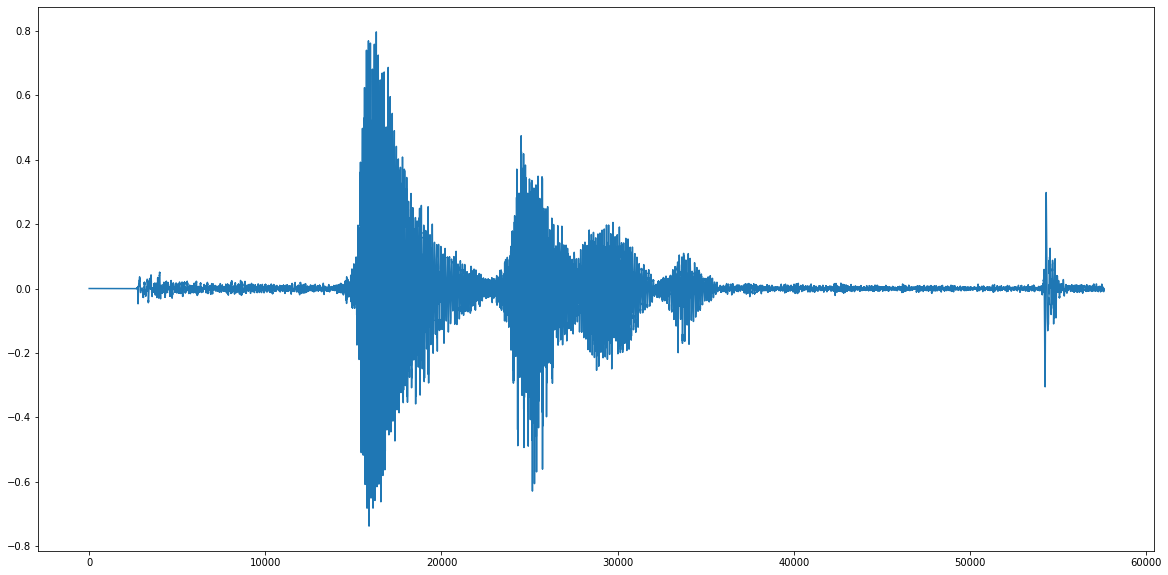

In [9]:
plt.figure(figsize=(20,10))
plt.plot(audio)
plt.show()

In [17]:
lang = 'en'
dur = 11

In [18]:
# use the audio file as the audio source
r = sr.Recognizer()
with sr.AudioFile(audio_file) as source:
    audio = r.record(source, duration=dur)  # read the entire audio file

In [19]:
# recognize speech using Google Speech Recognition
try:
    # for testing purposes, we're just using the default API key
    # to use another API key, use `r.recognize_google(audio, key="GOOGLE_SPEECH_RECOGNITION_API_KEY")`
    # instead of `r.recognize_google(audio)`
    print("Google Speech Recognition thinks you said: " + r.recognize_google(audio, language=lang))
except sr.UnknownValueError:
    print("Google Speech Recognition could not understand audio")
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))

Google Speech Recognition thinks you said: how how are you
